In [1]:
import meshio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


mesh_file = "case1_T00_lung_regions_11.xdmf"
mesh = meshio.read(mesh_file)

# Display basic information about the mesh
print("Mesh Summary:")
print("--------------")
print("Number of points:", mesh.points.shape[0])
print("Point coordinates shape:", mesh.points.shape)

print("\nCell types available:")
for cell_block in mesh.cells:
    print(f"  Cell type: {cell_block.type}, Number of cells: {cell_block.data.shape[0]}")

print("\nCell Data Keys:")
print(list(mesh.cell_data.keys()))

# Print the first 10 c_labels values for tetrahedral cells (assuming "c_labels" is in cell_data)
c_labels = mesh.cell_data["c_labels"][0]
print("\nFirst 10 c_labels for tetrahedral cells:")
print(c_labels[:10])


Mesh Summary:
--------------
Number of points: 9471
Point coordinates shape: (9471, 3)

Cell types available:
  Cell type: tetra, Number of cells: 48024

Cell Data Keys:
['c_labels']

First 10 c_labels for tetrahedral cells:
[4 7 4 4 1 3 1 4 7 4]


In [ ]:
# extract tetrahedral connectivity.
tetra = mesh.cells_dict["tetra"]  # shape (N_tets, 4)
n_tets = tetra.shape[0]
print(f"\nTotal number of tetrahedral elements: {n_tets}")

print("\nFirst 10 tetrahedral elements (vertex indices):")
for i in range(min(10, n_tets)):
    print(f"Element {i}: {tetra[i]}")





Total number of tetrahedral elements: 48024

First 10 tetrahedral elements (vertex indices):
Element 0: [6338 7395 1340 1435]
Element 1: [3857  956 1224 1473]
Element 2: [6278 5566 8432 5573]
Element 3: [8352 9426 8333 7685]
Element 4: [1823 4340 6420 8319]
Element 5: [3449 4112 5299 4964]
Element 6: [4632 4675 9279 7545]
Element 7: [1852 6254 6864 5577]
Element 8: [8582 5382 4124  478]
Element 9: [9311 5580 6182 2774]


In [4]:
# Build a dictionary to map each triangular face (a sorted tuple of 3 vertex indices)
# to the tetrahedron indices that share it.
face2tets = {}
for t_idx, tet in enumerate(tetra):
    # A tetrahedron with vertices [v0, v1, v2, v3] has 4 faces:
    faces = [
        tuple(sorted((tet[0], tet[1], tet[2]))),
        tuple(sorted((tet[0], tet[1], tet[3]))),
        tuple(sorted((tet[0], tet[2], tet[3]))),
        tuple(sorted((tet[1], tet[2], tet[3])))
    ]
    for face in faces:
        face2tets.setdefault(face, []).append(t_idx)

# find adjacent tetrahedra (sharing one face) whose c_labels differ.
# collect pairs as tuples: (face, tetra_index1, tetra_index2)
adjacent_pairs = []
if "c_labels" in mesh.cell_data:
    c_labels = mesh.cell_data["c_labels"][0]
    for face, tet_list in face2tets.items():
        if len(tet_list) > 1:
            # Check each distinct pair in the list
            for i in range(len(tet_list)):
                for j in range(i+1, len(tet_list)):
                    t1, t2 = tet_list[i], tet_list[j]
                    if c_labels[t1] != c_labels[t2]:
                        adjacent_pairs.append((face, t1, t2))
else:
    print("No 'c_labels' found; cannot compare material IDs.")

print(f"\nFound {len(adjacent_pairs)} pairs of adjacent tetrahedra with different c_labels.")
print("Printing up to the first 10 pairs:")
for idx, (face, t1, t2) in enumerate(adjacent_pairs[:10]):
    print(f"Pair {idx}: Shared Face {face}, Tetra {t1} (c_label={c_labels[t1]}), Tetra {t2} (c_label={c_labels[t2]})")


Found 12739 pairs of adjacent tetrahedra with different c_labels.
Printing up to the first 10 pairs:
Pair 0: Shared Face (956, 1224, 3857), Tetra 1 (c_label=7), Tetra 46334 (c_label=2)
Pair 1: Shared Face (956, 1473, 3857), Tetra 1 (c_label=7), Tetra 12232 (c_label=2)
Pair 2: Shared Face (1224, 1473, 3857), Tetra 1 (c_label=7), Tetra 27476 (c_label=2)
Pair 3: Shared Face (956, 1224, 1473), Tetra 1 (c_label=7), Tetra 30394 (c_label=2)
Pair 4: Shared Face (478, 4124, 8582), Tetra 8 (c_label=7), Tetra 25525 (c_label=4)
Pair 5: Shared Face (2941, 5827, 6513), Tetra 12 (c_label=4), Tetra 10090 (c_label=7)
Pair 6: Shared Face (5315, 6002, 8634), Tetra 15 (c_label=7), Tetra 41898 (c_label=4)
Pair 7: Shared Face (5375, 8204, 8207), Tetra 19 (c_label=4), Tetra 28949 (c_label=7)
Pair 8: Shared Face (5199, 8204, 8207), Tetra 19 (c_label=4), Tetra 43040 (c_label=7)
Pair 9: Shared Face (5051, 5956, 8412), Tetra 22 (c_label=1), Tetra 467 (c_label=7)



Visualizing Tetra 1 and Tetra 46334 (different c_labels: 7 vs 2) sharing face (956, 1224, 3857)


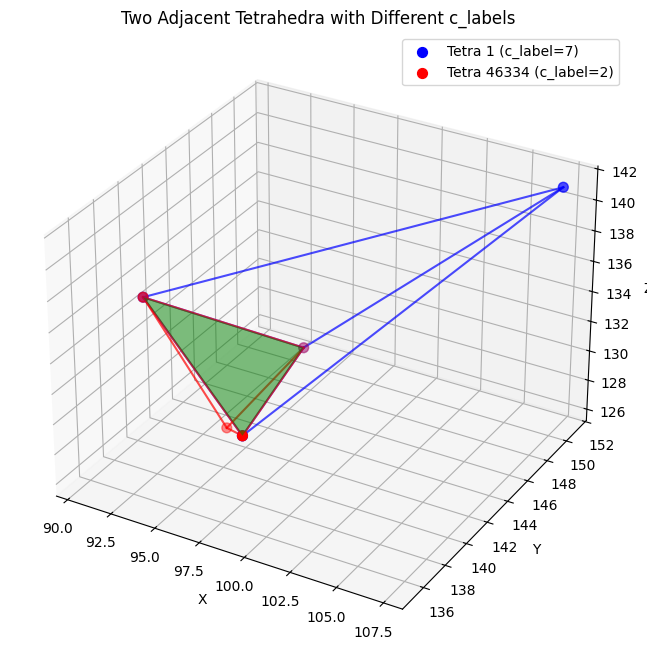

In [5]:
# Visualize the first adjacent pair with different c_labels (if any)
if adjacent_pairs:
    face, t1, t2 = adjacent_pairs[0]
    T1 = tetra[t1]
    T2 = tetra[t2]
    
    print(f"\nVisualizing Tetra {t1} and Tetra {t2} (different c_labels: {c_labels[t1]} vs {c_labels[t2]}) sharing face {face}")
    
    # Setup the 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    def plot_tetra(tet, color, label, alpha=0.7):
        pts = mesh.points[tet]
        # Six edges of a tetrahedron
        edges = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]
        for e in edges:
            p_start = pts[e[0]]
            p_end = pts[e[1]]
            ax.plot([p_start[0], p_end[0]],
                    [p_start[1], p_end[1]],
                    [p_start[2], p_end[2]], color=color, alpha=alpha)
        ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], color=color, s=50, label=label)
    
    # Plot the two tetrahedra
    plot_tetra(T1, color='blue', label=f"Tetra {t1} (c_label={c_labels[t1]})")
    plot_tetra(T2, color='red', label=f"Tetra {t2} (c_label={c_labels[t2]})")
    
    # Highlight the shared face in green
    shared_pts = mesh.points[list(face)]
    shared_face_poly = Poly3DCollection([shared_pts], alpha=0.5, facecolor='green')
    ax.add_collection3d(shared_face_poly)
    
    ax.set_title("Two Adjacent Tetrahedra with Different c_labels")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.show()
else:
    print("No adjacent tetrahedra with different c_labels were found.")
